# Dominik 2024

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('qDNA-default')

In [2]:
# parameters
register_config = [('NV', (0, 0, 0), 0, {})]
spin_type, abundancy, rmin, rmax = 'C13', 0.5e-2, 0, 4e-9

# bath config 
# bath_configs = [SpinBath(spin_type, abundancy, rmin, rmax, seed=1, init_state_idx=0).config]

filename, directory = 'miri_bath', os.getcwd()
# spin_type, abundancy, rmin, rmax, num_baths, num_init_states = 'C13', 0.5e-2, 0, 4e-9, 1, 100
# save_spin_baths(filename, directory, spin_type, abundancy, rmin, rmax, num_baths, num_init_states)

bath_configs = list( load_spin_baths(filename, directory).values())

# kwargs
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False,
              old_state=q.qeye(2), target=q.qeye(2), env_approx_level='no_bath')

In [3]:
# -------------
# C13 positions
# -------------
# C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
# C13_pos = (8.73e-10, 0.0, 1.86e-10) # rounded coordinates yield the same fidelities
# C13_pos = (4.722331100730915e-10, 0.0, 1.030637866442101e-10) # Dennis 

# -----------------------
# target gates and states
# -----------------------

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )

# CNOT
cnot_gate = get_cnot_gate(2, 0, 1)
cnot_state = cnot_gate * init_state * cnot_gate.dag()

# Hadamard
hada_gate = get_hada_gate(2, 1)
hada_state = hada_gate * init_state * hada_gate.dag()

# Bell (Hadamard and CNOT)
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

# ---------------
# Pulse Sequences
# ---------------

# Suter Hadamard gate
# pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2]

# Suter CNOT gate
# pulse_seq = [3.78e-6, 2.11e-6, 2.15e-6, 0.63e-6, 1.88e-6, 3.96e-6, 1.9e-6, 0, np.pi/5, np.pi/2] 

# Dominik Bell state (without DD)
# pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]

# Dominik Bell state (with DD)
# pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6, -1.06, 4.68, 2.07, 0, -0.53, 6.26, -1.76, 0]

In [4]:
# parameters
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
bath_configs = list( load_spin_baths('Dominik_C13', DATA_DIR).values() )[:10]

kwargs = dict(suter_method=True, instant_pulses=True, verbose=False,
             old_state=bell_state, target=bell_state, env_approx_level='no_bath')

## Effect of the spin bath for free time evolution

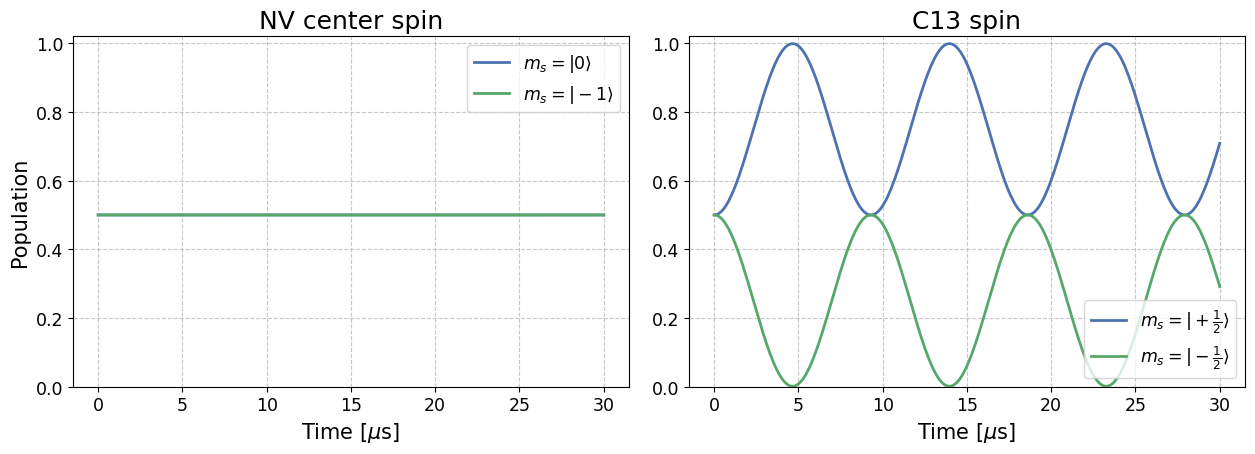

In [4]:
# free time evolution of the entangled Bell state between NV center and C13 spin (Dominik Fig. 4)

kwargs['env_approx_level'] = 'no_bath'
env = Environment(register_config, bath_configs, **kwargs)
env.pulse_seq = [30e-6]

t_list = env.get_t_list(stepsize=0.1e-6)
    
new_states_full = env.calc_new_states_full(t_list)
new_states = new_states_full[0]
fig, ax = plot_pops(t_list, new_states)

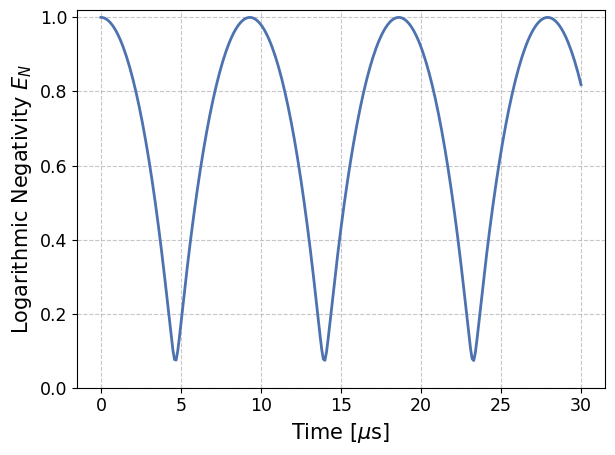

In [5]:
log_negativities = [calc_logarithmic_negativity(new_state) for new_state in new_states] 
fig, ax = plot_log_negativity(t_list, log_negativities)

### Results for different approximation levels

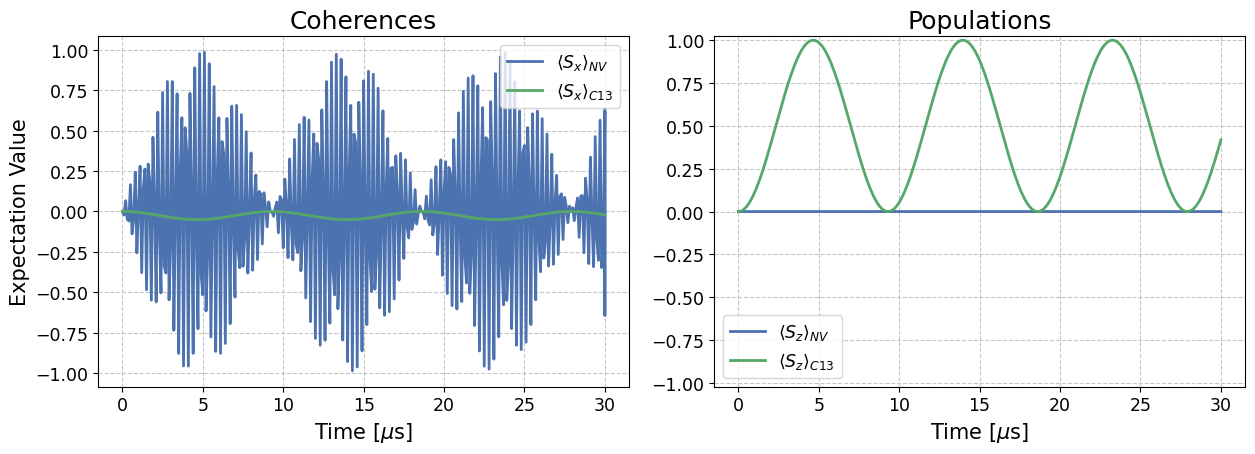

In [5]:
# no_bath
fig, ax = plot_exp_values(t_list, new_states)

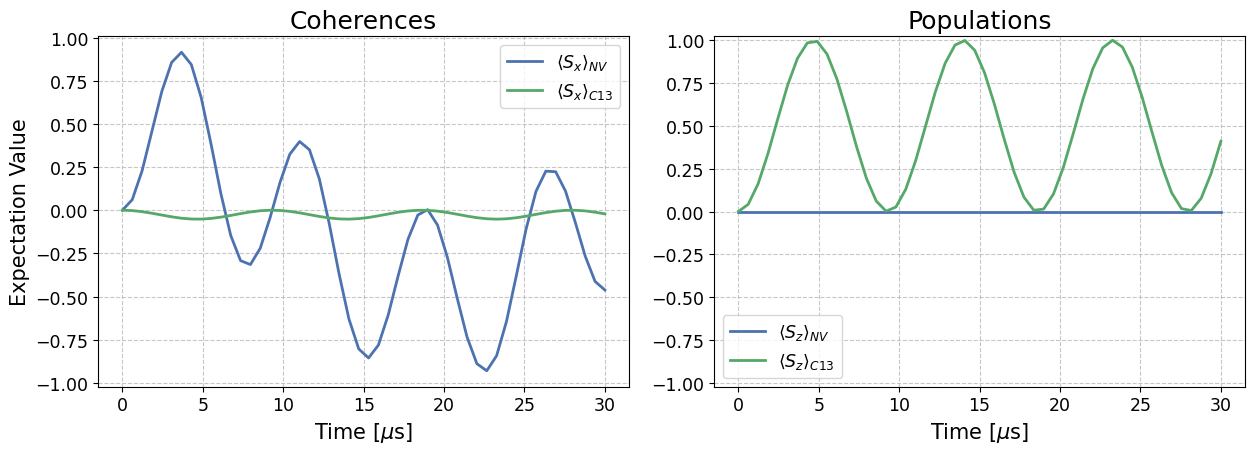

In [13]:
# gCCE0
fig, ax = plot_exp_values(t_list, new_states)

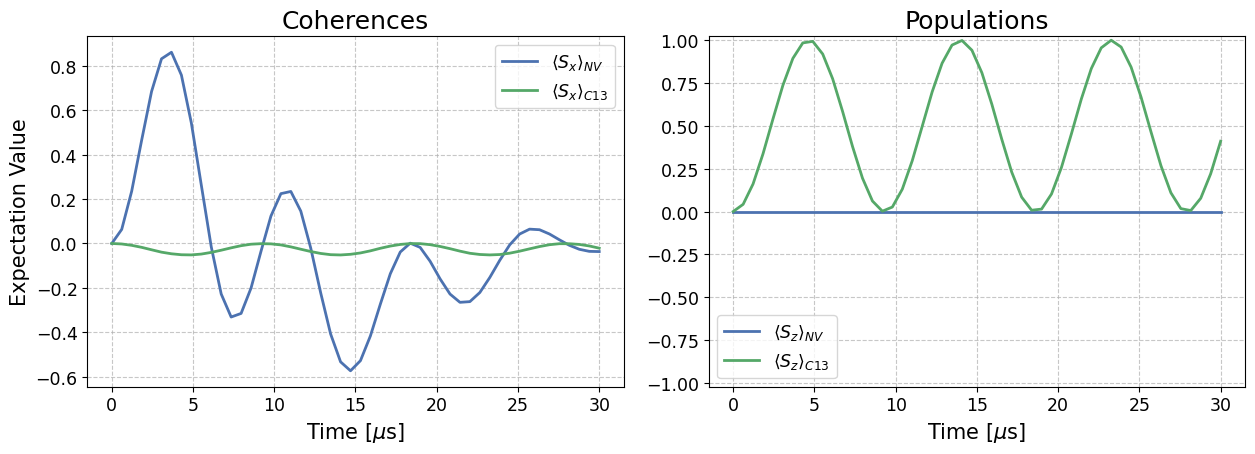

In [20]:
# gCCE1
fig, ax = plot_exp_values(t_list, new_states)

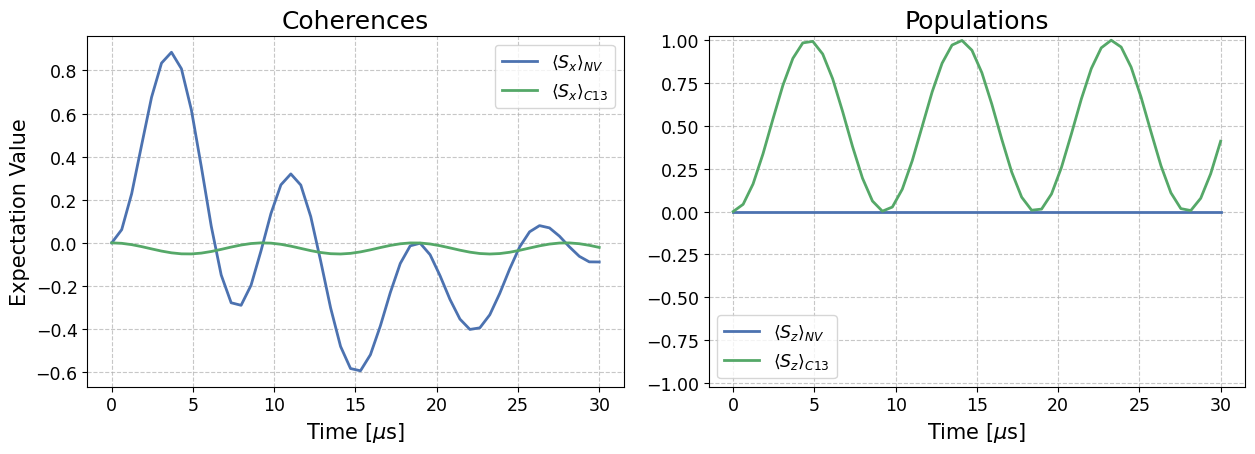

In [24]:
# full_bath
fig, ax = plot_exp_values(t_list, new_states)

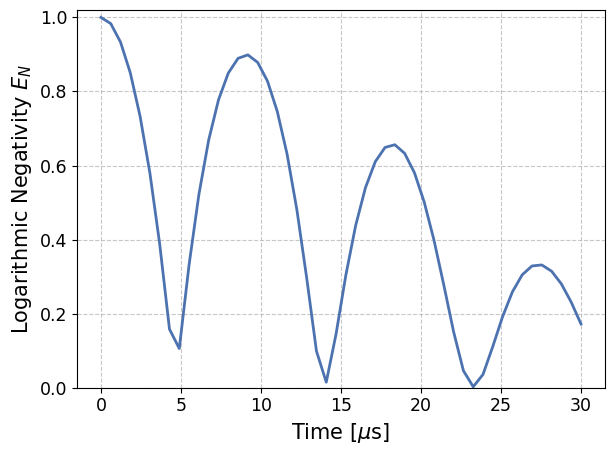

In [26]:
# full_bath
log_negativities = [calc_logarithmic_negativity(new_state) for new_state in new_states] 
fig, ax = plot_log_negativity(t_list, log_negativities)

## Bell State Preparation with Dynamical Decoupling (Dominik, Fig. 7)

In [8]:
kwargs['dynamical_decoupling'] = True

env = Environment(register_config, bath_configs, **kwargs)
env.old_state = None
env.pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6,       -1.06, 4.68, 2.07, 0,     -0.53, 6.26, -1.76, 0]

new_states_full = env.calc_new_states_full([env.total_time])
env.calc_fidelities_full(new_states_full)

[[np.float64(0.9982118533034092)]]

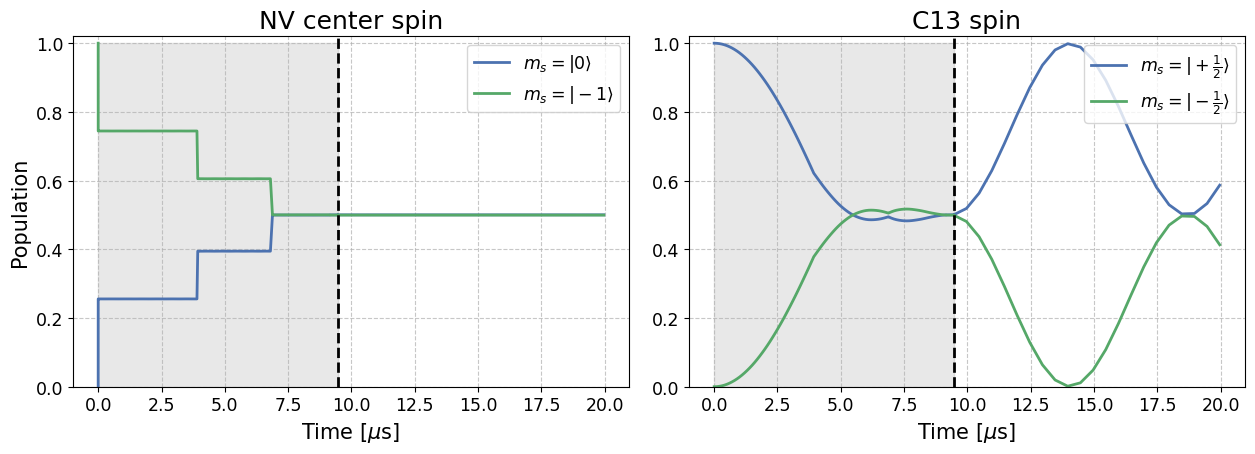

In [5]:
t_list = env.get_t_list(stepsize=0.1e-6)
t_list.extend( np.arange(env.total_time, 20e-6, 0.5e-6) )
    
new_states_full = env.calc_new_states_full(t_list)
new_states = new_states_full[0]
fig, ax = plot_pops(t_list, new_states, pulse_time=env.total_time)

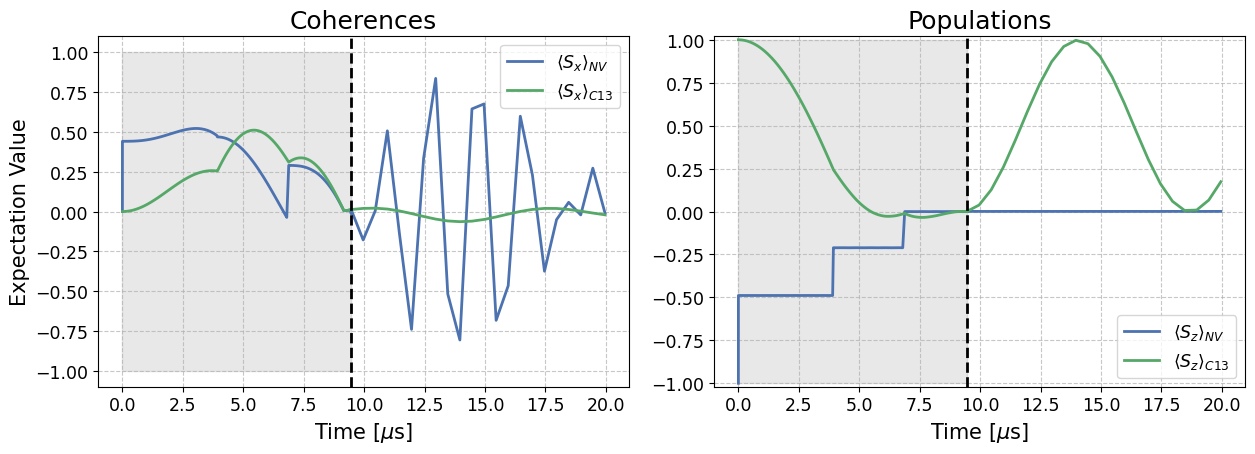

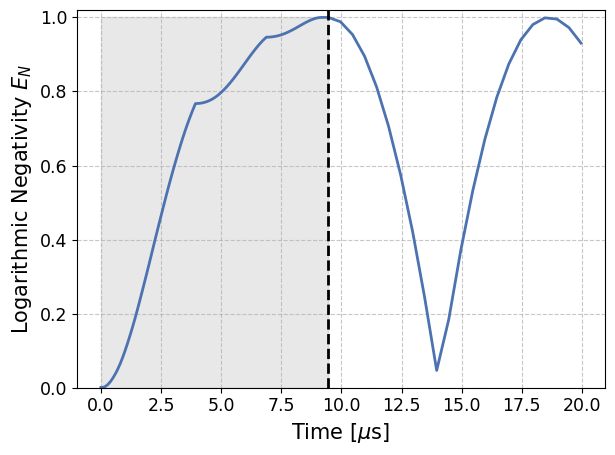

In [6]:
fig, ax = plot_exp_values(t_list, new_states, pulse_time=env.total_time)

log_negativities = [calc_logarithmic_negativity(new_state) for new_state in new_states] 
fig, ax = plot_log_negativity(t_list, log_negativities, pulse_time=env.total_time)

## Bell State Preparation (Dominik, Fig. 4)

In [6]:
kwargs['dynamical_decoupling'] = False

env = Environment(register_config, bath_configs, **kwargs)
env.pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]

new_states_full = env.calc_new_states_full([env.total_time])
env.calc_fidelities_full(new_states_full)

[[np.float64(0.9997793580221668)]]

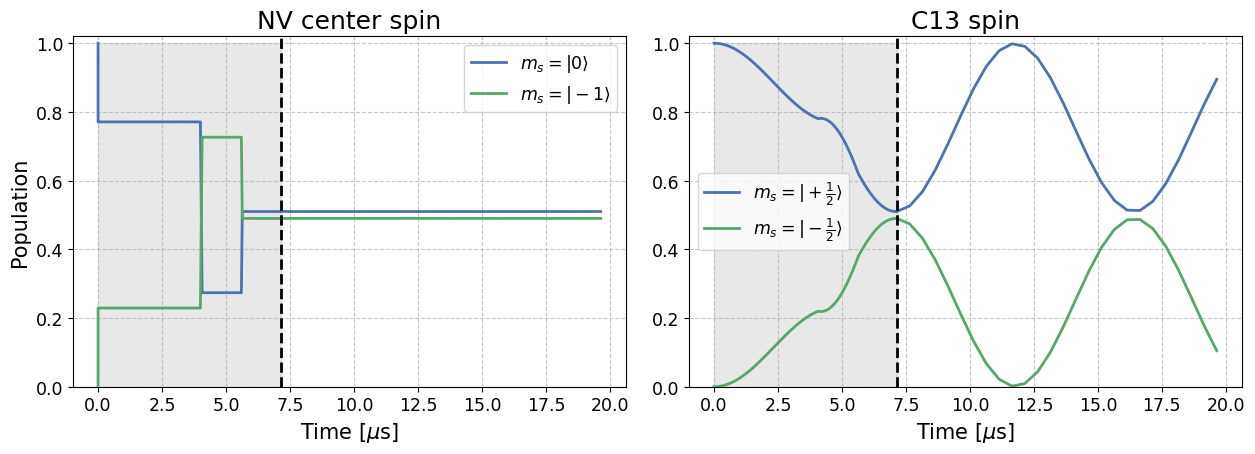

In [8]:
t_list = env.get_t_list(stepsize=0.1e-6)
t_list.extend( np.arange(env.total_time, 20e-6, 0.5e-6) )
    
new_states_full = env.calc_new_states_full(t_list)
new_states = new_states_full[0]
fig, ax = plot_pops(t_list, new_states, pulse_time=env.total_time)

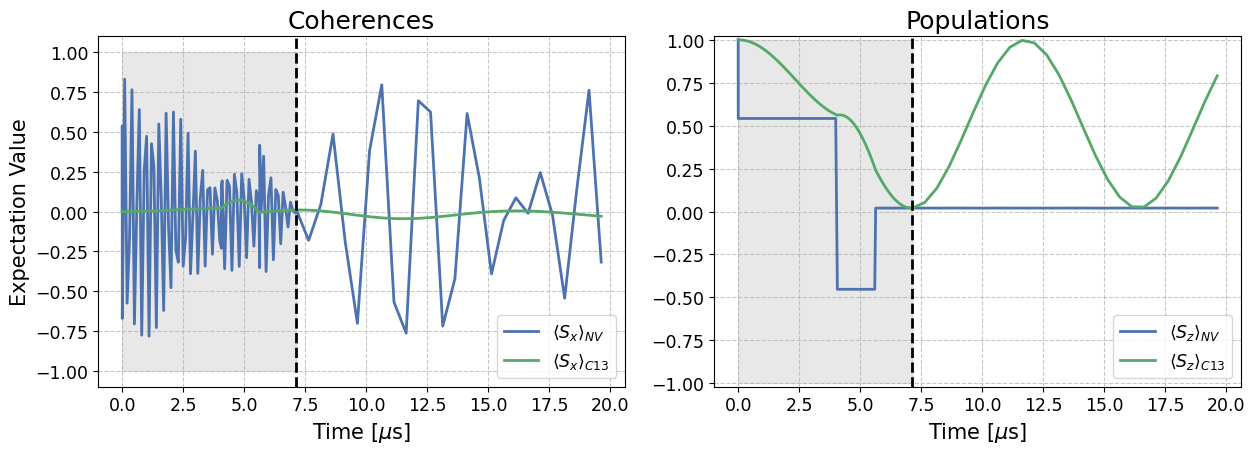

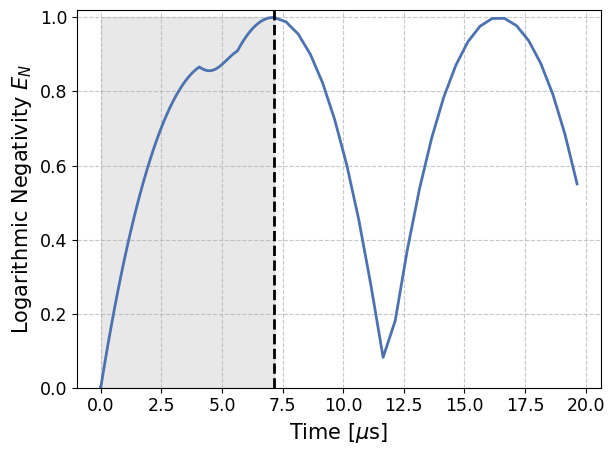

In [9]:
fig, ax = plot_exp_values(t_list, new_states, pulse_time=env.total_time)

log_negativities = [calc_logarithmic_negativity(new_state) for new_state in new_states] 
fig, ax = plot_log_negativity(t_list, log_negativities, pulse_time=env.total_time)